In [25]:
import os

openai_api_key=os.getenv("openai_api_key")
AZURE_OPENAI_DEPLOYMENT_NAME = os.getenv('deployment_name')
AZURE_OPENAI_ENDPOINT = os.getenv("endpoint")
AZURE_OPENAI_API_VERSION = os.getenv("version")

In [26]:
groq_api_key = os.getenv("groq_api_key")
from langchain_groq import ChatGroq
llm=ChatGroq(groq_api_key=groq_api_key)

In [27]:
from langchain.chat_models import AzureChatOpenAI

llm= AzureChatOpenAI(
    deployment_name=AZURE_OPENAI_DEPLOYMENT_NAME,
    openai_api_base=AZURE_OPENAI_ENDPOINT,
    openai_api_key=openai_api_key,
    openai_api_version=AZURE_OPENAI_API_VERSION
)

d:\Yash-Python\Lib\site-packages\langchain_community\chat_models\azure_openai.py:174: UserWarning: As of openai>=1.0.0, Azure endpoints should be specified via the `azure_endpoint` param not `openai_api_base` (or alias `base_url`). Updating `openai_api_base` from https://soa-openai-sc.openai.azure.com/ to https://soa-openai-sc.openai.azure.com/openai.
  warnings.warn(
d:\Yash-Python\Lib\site-packages\langchain_community\chat_models\azure_openai.py:181: UserWarning: As of openai>=1.0.0, if `deployment_name` (or alias `azure_deployment`) is specified then `openai_api_base` (or alias `base_url`) should not be. Instead use `deployment_name` (or alias `azure_deployment`) and `azure_endpoint`.
  warnings.warn(
d:\Yash-Python\Lib\site-packages\langchain_community\chat_models\azure_openai.py:189: UserWarning: As of openai>=1.0.0, if `openai_api_base` (or alias `base_url`) is specified it is expected to be of the form https://example-resource.azure.openai.com/openai/deployments/example-deployme

In [28]:
from langchain_core.tools import Tool
from langchain_google_community import GoogleSearchAPIWrapper

search = GoogleSearchAPIWrapper(
    k=2
)

google_search = Tool(
    name="google_search",
    func=search.run,
    description="Search Engine",
    max_tokens=500
)

In [29]:
from typing import TypedDict, List, Dict, Optional

class State(TypedDict):
    query:str
    context:Optional[str]
    output_1:List[str]
    products_list:Dict[str,str]
    t_n_f_list:List[Dict[str,str]]
    output_2:List[str]


In [30]:
def google(state:State):
    return {"context":google_search.invoke(state["query"])}

In [31]:
google_search.invoke("hi")

'The official website of the Aloha State. Home Search Search Online Services | Government Directory Latest News Agencies State Calendar State Officials Social\xa0... Buy, Trade, Send and Earn Crypto & Fiat. Deposit Bitcoin, ETH, USDT and other cryptos and start earning. Get the hi Debit Card and Multi-Currency IBAN\xa0...'

In [32]:
def query_enrich(state:State):
    system_prompt = f"""
        You are given a product description along with some context. Your task is to extract relevant information and return it as a structured. It should include fields such as the product's quantity, name, and no additional details that can be inferred from the context.
        Only give the output, no description is needed.
        Query:{state['query']}
        Context:{state['context']}
        Output:
        Product:(Porduct name, N/A if not found),
        Dimension:(Product Dimension, N/A if not found),
        Enriched Query:(Enriched Query, N/A if not found),
        
        MUST INCLUDE THESE THREE PARAMETERS IN OUTPUT.
        
        Example Input:

        Query: 2 in x 2 in x 3/4 in thrd tee C.S
        Context: 
        The query refers to a 2-inch by 2-inch by 3/4-inch threaded tee fitting made of carbon steel (C.S.). A tee fitting is a pipe connector with three ends, typically used to branch a pipe in a plumbing or piping system. The dimensions, "2 in x 2 in x 3/4 in," indicate that the main diameter size for the two primary connections is 2 inches, while the branch diameter is 3/4 inches.

        Expected Output: (This just an example)
        Product: Threaded tee,
        Dimension: 2 in x 2 in x 3/4 in,
        Enriched Query: 2-inch by 2-inch by 3/4-inch threaded tee fitting made of carbon steel (C.S.)
        """
    response=llm.invoke(system_prompt)  # Changed from llm() to llm.invoke()

    resp = [
        {text[0].strip(): text[1].strip()}
        for i in response.content.split(',')
        if (text := i.split(":")) and len(text) == 2
    ]
    single_dict = {k: v for d in resp for k, v in d.items()}

    return {"output_1":response}

In [33]:
from langchain_core.prompts import ChatPromptTemplate
def product_find(state: State):
    system_prompt = """
    You are an expert at matching user queries with inventory items. Given a set of **product details** from a user and an **inventory list** of products, evaluate if the user-provided details match any of the items in the inventory. For a match to be valid, the following conditions must be met:

    1) The **dimensions** of the product in the inventory must exactly match the dimensions provided by the user, in the same order and format, with no additions or omissions.
    2) The **product name** in the inventory must exactly match the product name specified by the user.

    **User-Provided Product Details:**
    {Product_details}

    **Inventory List:**
    {inventory}
    

    **Expected Output:**
    Product: true/false, 
    Dimension: true/false

    ONLY GIVE OUPUT IN THE GIVEN FORMAT, NO EXTRA INFORMATION, SYMBOLS, TOKEN OR ANY OTHER TEXT IS NECESSARY
    """
    template = ChatPromptTemplate({
        ("system",system_prompt),
    })
    output=[]
    for prod_list in state['products_list']:
        prompt_value=template.invoke(
            {
                "Product_details":state['output_1'],
                "inventory":prod_list
            }
        )
        response=llm.invoke(prompt_value)
        temp=list(response.content.split(','))
        d = {}
        for item in temp:
            key, value = item.split(':')
            d[key.strip()] = value.strip()  # Strip whitespace from both key and value
        output.append(d)
    
    return {"t_n_f_list":output}

        

In [34]:
from langchain_core.prompts import ChatPromptTemplate
def product_find_1():
    system_prompt = """
    You are an expert at matching user queries with inventory items. Given a set of **product details** from a user and an **inventory list** of products, evaluate if the user-provided details match any of the items in the inventory. For a match to be valid, the following conditions must be met:

    1) The **dimensions** of the product in the inventory must exactly match the dimensions provided by the user, in the same order and format, with no additions or omissions.
    2) The **product name** in the inventory must exactly match the product name specified by the user.

    **User-Provided Product Details:**
    {Product_details}

    **Inventory List:**
    {inventory}
    

    **Expected Output:**
    Product: true/false, 
    Dimension: true/false

    ONLY GIVE OUPUT IN THE GIVEN FORMAT, NO EXTRA INFORMATION, SYMBOLS, TOKEN OR ANY OTHER TEXT IS NECESSARY
    """
    template = ChatPromptTemplate({
        ("system",system_prompt),
    })
    output=[]
    for prod_list in range(1):
        prompt_value=template.invoke(
            {
                "Product_details":" Dimension: 2 in x 2 in x 3/4 in, Product Name: Threaded tee",
                "inventory":"Product_id: 13061100204,description: bmi tee 2x3/4x2 2x3/4x2 blk mi tee ward 2xex2bmt 2x3/4x2in bmi red t"
            }
        )
        response=llm.invoke(prompt_value)
        temp=list(response.content.split(', '))
        out={
                f"{temp[0].split(': ')[0]}":f"{temp[0].split(': ')[1]}",
                f"{temp[1].split(': ')[0]}":f"{temp[1].split(': ')[1]}",
            }
        output.append(out)
    
    return output

        

In [35]:
res=product_find_1()

In [36]:
res[0]

{'Product': 'false', '\nDimension': 'false'}

In [50]:
temp = []

ck=[{'Product': 'false', 'Dimension': 'false'},
 {'Product': 'false', 'Dimension': 'false'},
 {'Product': 'false', 'Dimension': 'false'}]
for i in range(len(ck)):
    # Ensure that each item in t_n_f_list is a dictionary
    current_dict = ck[i]
    if current_dict['Product']=='true' and current_dict['Dimension']=='true':
        temp.append(products_list_1[i])

print(temp)

[]


In [51]:
def filter(state: State):
    temp = []
    for i in range(len(state['t_n_f_list'])):
        # Ensure that each item in t_n_f_list is a dictionary
        current_dict = state['t_n_f_list'][i]
        if current_dict['Product']=='true' or current_dict['Dimension']=='true':
            temp.append(state['products_list'][i])
        

    return {'output_2': temp}

In [52]:
from langgraph.graph import StateGraph, START, END

graph_builder = StateGraph(State)

graph_builder.add_node("search", google)
graph_builder.add_node("enrichment",query_enrich)
graph_builder.add_node("product",product_find)
graph_builder.add_node('filter_product',filter)

graph_builder.add_edge(START,"search")
graph_builder.add_edge("search","enrichment")
graph_builder.add_edge("enrichment","product")
graph_builder.add_edge("product","filter_product")
graph_builder.add_edge("filter_product",END)

In [53]:
graph=graph_builder.compile()

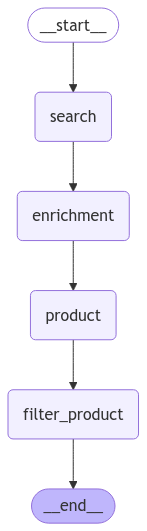

In [54]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:

    pass

In [55]:
user_input="2 in x 2 in x 3/4 in thrd tee C.S"

In [56]:
products_list_1=[
    {
        "Product_id": "13061100204",
        "description": "bmi tee 2x3/4x2 2x3/4x2 blk mi tee ward 2xex2bmt 2x3/4x2in bmi red t"
    },
    {
        "Product_id": "13061100236",
        "description": "2x3/4 blk mi tee ward 2xebmt 2x2x3/4 bmi red tee bmi tee 2x3/4"
    },
    {
        "Product_id": "13161100204",
        "description": "ibmi tee2x3/4x2 2x3/4x2 blk imi tee sci 33rt1020006020c 2x3/4x2 lf mi t ibmi tee 2x3/4x2"
    }
]

In [57]:
products_list=[
    {
        "Product_id": "13061100204",
        "description": "bmi tee 2x3/4x2 2x3/4x2 blk mi tee ward 2xex2bmt 2x3/4x2in bmi red t"
    },
    {
        "Product_id": "13061100236",
        "description": "2x3/4 blk mi tee ward 2xebmt 2x2x3/4 bmi red tee bmi tee 2x3/4"
    },
    {
        "Product_id": "13161100204",
        "description": "ibmi tee2x3/4x2 2x3/4x2 blk imi tee sci 33rt1020006020c 2x3/4x2 lf mi t ibmi tee 2x3/4x2"
    },
    {
        "Product_id": "13061100211",
        "description": "2x1x2 blk mi tee ward 2x1x2bmt 2x1x2in bmi red tee bmi tee 2x1x2"
    },
    {
        "Product_id": "13161100236",
        "description": "ibmi tee 2x3/4 2x2x3/4 blk imi tee sci 33rt1020006c 2x3/4 lf 150 mi t"
    },
    {
        "Product_id": "23161100238",
        "description": "phx tee-red-thd-3m-2x2x1 frgd stl dom fs a105 3000 teethrd 2x1 2 x 2 x 1 3m thd red tee phx tee-red-thd-3m-2x2x1 frgd stl dom fs a105 3000# tee thrd 2x1"
    },
    {
        "Product_id": "13061100220",
        "description": "2x1-1/4x2 blk mi tee ward 2x1bx2bmt 2x1-1/4x2in bmi tee bmi tee 2x11/4x2"
    },
    {
        "Product_id": "13061100238",
        "description": "2x1 blk mi tee ward 2x1bmt 2x2x1in bmi red tee bmi tee 2x1"
    },
    {
        "Product_id": "15061100236",
        "description": "ci 2x2x3/4 screwed tee sci 37rt1020006 2x2x3/4 lf red t bci tee 2x3/4"
    },
    {
        "Product_id": "13061100232",
        "description": "2x1-1/2x2 blk mi tee ward 2x1dx2bmt 2x1-1/2x2in bmi tee bmi tee 2x11/2x2"
    },
    {
        "Product_id": "13161100211",
        "description": "2x1x2 blk imi tee sci 33rt1020010020c 2x1x2 lf 150 t ibmi tee 2x1x2"
    },
    {
        "Product_id": "n83261100186",
        "description": "ss t304 3000# thrd tee 11/2x3/4"
    },
    {
        "Product_id": "n83261100092",
        "description": "ss 304 3000# thrd tee 3/4x1/2"
    },
    {
        "Product_id": "23161100234",
        "description": "dom fs a105 3000 teethrd 2x1/2 phx tee-red-thd-3m-2x2x1/2 frgd stl 2 x 2 x 1/2 3m thd red tee phx tee-red-thd-3m-2x2x1/2 frgd stl dom fs a105 3000# tee thrd 2x1/2"
    },
    {
        "Product_id": "n61061100088",
        "description": "rb tee 3/4x1/4"
    },
    {
        "Product_id": "n61061100064",
        "description": "rb tee 1/2x3/4"
    },
    {
        "Product_id": "n15061100204",
        "description": "bci tee 2x3/4x2"
    },
    {
        "Product_id": "n61061100043",
        "description": "rb tee 3/8x1/4"
    },
    {
        "Product_id": "n13561100236",
        "description": "bxh tee 2x3/4"
    },
    {
        "Product_id": "23161100236",
        "description": "dom fs a105 3000 teethrd 2x3/4 2 x 2 x 3/4 3m thd red tee phx tee-red-thd-3m-2x2-3/4 frgd stl phx tee-red-thd-3m-2x2-3/4 frgd stl dom fs a105 3000# tee thrd 2x3/4"
    },
    {
        "Product_id": "n61061100090",
        "description": "rb tee 3/4x3/8"
    },
    {
        "Product_id": "17061110294",
        "description": "7064 21/2x21/2x2 ptd thrd brch red tee anv 7064-ptd-2-1/2x2-1/2x2 tee grv x thrd tee 21/2x2"
    },
    {
        "Product_id": "17061110342",
        "description": "7064 3x3x2 ptd thrd brch red tee anv 7064-ptd-3x3x2 tee grv x thrd tee 3x2"
    },
    {
        "Product_id": "17061110436",
        "description": "7064 4x4x2 ptd thrd brch red tee anv 7064-ptd-4x4x2 tee grv x thrd tee 4x2"
    },
    {
        "Product_id": "23161100242",
        "description": "dom fs a105 3000 teethrd 2x1-1/2 2 x 2 x 1-1/2 3m thd red tee phx tee-red-thd-3m-2x2x1-1/2 f/s phx tee-red-thd-3m-2x2x1-1/2 f/s dom fs a105 3000# tee thrd 2x11/2"
    },
    {
        "Product_id": "23061100238",
        "description": "fs a105 3000 tee thrd 2x1 2 x1 3000 th rtee forged sci 42rt3020010 2x1 3000 f/s tee fs a105 3000# tee thrd 2x1"
    },
    {
        "Product_id": "23061100242",
        "description": "fs a105 3000 tee thrd2x1-1/2 2 x1 1/2 3000 th rtee forged sci 42rt3020014 2x1-1/2 3000 f/s t fs a105 3000# tee thrd 2x11/2"
    },
    {
        "Product_id": "15161100234",
        "description": "di 2x2x1/2 screwed tee sci 35rt3020004 2x1/2 lf thrd red t bdi tee 2x1/2"
    },
    {
        "Product_id": "15161100236",
        "description": "di 2x2x3/4 screwed tee sci 35rt3020006 2x3/4 lf thrd red t bdi tee 2x3/4"
    },
    {
        "Product_id": "22061100200",
        "description": "2 2000 thrd tee forged sci 42t-2020 2in 2000 f/s thrd tee fs a105 2000 tee thrd 2 fs a105 2000# tee thrd 2"
    },
    {
        "Product_id": "23061100200",
        "description": "fs a105 3000 tee thrd 2 2 3000 thrd tee forged sci 42t-3020 2in 3000 f/s thrd tee fs a105 3000# tee thrd 2"
    },
    {
        "Product_id": "40802230200",
        "description": "butterfly valvewaferlever handleci bodyalmn/brnz disc200 wogepdm liner m-vco cw223e-2in ci/ab bfly vlv mil cw223e waf bfv w/hdl 2"
    },
    {
        "Product_id": "n17061110236",
        "description": "grv x thrd tee 2x3/4"
    },
    {
        "Product_id": "n23061100236",
        "description": "fs 3000# tee thrd 2x3/4"
    },
    {
        "Product_id": "65061100204",
        "description": "cop w tee 611 2x3/4x2 611rr 2x3/4x2 cxcxc tee wrot nibco 611rr-2x3/4x2 tee cop w tee #611 2x3/4x2"
    },
    {
        "Product_id": "n17061110238",
        "description": "grv x thrd tee 2x1"
    },
    {
        "Product_id": "n17061110510",
        "description": "grv x thrd tee 5x2"
    },
    {
        "Product_id": "n17061110604",
        "description": "grv x thrd tee 6x2"
    },
    {
        "Product_id": "n17061110242",
        "description": "grv x thrd tee 2x11/2"
    },
    {
        "Product_id": "61061100236",
        "description": "rb tee2x3/4 2 x3/4 125 r tee brz sci 36rt1020006c 2x3/4 125 brz tee rb tee 2x3/4"
    },
    {
        "Product_id": "65061100236",
        "description": "611r 2x2x3/4 cxcxc tee wrot nibco 611r-2x2x3/4 cxcxc tee cop w tee 611 2x3/4 cop w tee #611 2x3/4"
    }
]

In [63]:
response = graph.invoke({
    "query":f"{user_input}",
    "products_list":products_list
})

In [64]:
response['output_2']

[{'Product_id': '13161100236',
  'description': 'ibmi tee 2x3/4 2x2x3/4 blk imi tee sci 33rt1020006c 2x3/4 lf 150 mi t'},
 {'Product_id': 'n61061100090', 'description': 'rb tee 3/4x3/8'},
 {'Product_id': '15161100236',
  'description': 'di 2x2x3/4 screwed tee sci 35rt3020006 2x3/4 lf thrd red t bdi tee 2x3/4'},
 {'Product_id': '65061100204',
  'description': 'cop w tee 611 2x3/4x2 611rr 2x3/4x2 cxcxc tee wrot nibco 611rr-2x3/4x2 tee cop w tee #611 2x3/4x2'}]

In [67]:
response['t_n_f_list'][0]['Product']

'false'